# DRC Roads Temporal Analysis



Keywords: temporal analysis, forest monitoring, classification

In [1]:
import datetime
import json
import os

import numpy as np
import pandas as pd
from planet import api

In [2]:
# Import functionality from local notebooks
from ipynb.fs.defs.drc_roads_download import get_overlapping_scenes, StripDownloader, StripSearcher
from ipynb.fs.defs.drc_roads_classification \
    import Timer, load_training_data, classify_forest, classified_band_to_rgb

## Download Scenes

In this section, we use the ipynb module to import `StripDownloader` from the [drc_roads_download](drc_roads_download.ipynb) notebook. We then use `StripDownloader` to download the portion of OrthoTile strips that overlap the AOI.

### Load data from drc_roads_download notebook

In [3]:
# load aoi. Saved in drc_roads_download notebook
aoi_geojson_filename = os.path.join('pre-data', 'aoi.geojson')

### Download portions of OrthoTile strips that overlap AOI

In [4]:
# create planet api client
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [5]:
# load aoi json
with open(aoi_geojson_filename) as json_data:
    aoi = json.load(json_data)

In [6]:
# get good overlapping scenes from to July 2017 to February 2018
begin=datetime.datetime(year=2017,month=7,day=1)
end=datetime.datetime(year=2018,month=3,day=1)
strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(aoi_geojson_filename)

500 OrthoTiles were returned from the api search.
There are 494 OrthoTiles that overlap aoi.
There are 144 OrthoTiles in 36 strips that significantly overlap the aoi.
36 strips
found data/1214499_udm_mosaic.tif
found data/1176905_udm_mosaic.tif
found data/1167439_udm_mosaic.tif
found data/1153620_udm_mosaic.tif
found data/1150329_udm_mosaic.tif
found data/1130991_udm_mosaic.tif
found data/1127986_udm_mosaic.tif
found data/1124454_udm_mosaic.tif
found data/1121892_udm_mosaic.tif
found data/1114901_udm_mosaic.tif
found data/1043874_udm_mosaic.tif
found data/1091588_udm_mosaic.tif
found data/1085449_udm_mosaic.tif
found data/1081381_udm_mosaic.tif
found data/1054596_udm_mosaic.tif
found data/1047845_udm_mosaic.tif
found data/1043827_udm_mosaic.tif
found data/1037433_udm_mosaic.tif
found data/1011123_udm_mosaic.tif
found data/993122_udm_mosaic.tif
found data/960830_udm_mosaic.tif
found data/943459_udm_mosaic.tif
found data/904538_udm_mosaic.tif
found data/915538_udm_mosaic.tif
found data/8

In [8]:
asset_type = 'analytic'
strip_downloader = StripDownloader(good_scenes, aoi_geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)

21 strips
found data/1176905_analytic_mosaic.tif
found data/1153620_analytic_mosaic.tif
found data/1130991_analytic_mosaic.tif
found data/1127986_analytic_mosaic.tif
found data/1124454_analytic_mosaic.tif
found data/1121892_analytic_mosaic.tif
found data/1114901_analytic_mosaic.tif
found data/1091588_analytic_mosaic.tif
found data/1085449_analytic_mosaic.tif
found data/1081381_analytic_mosaic.tif
found data/1047845_analytic_mosaic.tif
found data/1043827_analytic_mosaic.tif
found data/1037433_analytic_mosaic.tif
found data/943459_analytic_mosaic.tif
found data/758681_analytic_mosaic.tif
found data/741529_analytic_mosaic.tif
found data/739199_analytic_mosaic.tif
found data/699281_analytic_mosaic.tif
found data/651530_analytic_mosaic.tif
found data/666617_analytic_mosaic.tif
found data/636659_analytic_mosaic.tif
Nothing to download


### Get mosaic image names

In [9]:
# sort strip ids as integers. Strip id order is the same as strip temporal order
strip_ids = [int(s) for s in good_scenes.strip_id.unique().tolist()]
strip_ids.sort()
strip_ids = [str(s) for s in strip_ids]

In [10]:
strip_mosaics = [strip_downloader.get_filename(i, asset_type) for i in strip_ids]

In [11]:
strip_mosaics

['data/636659_analytic_mosaic.tif',
 'data/651530_analytic_mosaic.tif',
 'data/666617_analytic_mosaic.tif',
 'data/699281_analytic_mosaic.tif',
 'data/739199_analytic_mosaic.tif',
 'data/741529_analytic_mosaic.tif',
 'data/758681_analytic_mosaic.tif',
 'data/943459_analytic_mosaic.tif',
 'data/1037433_analytic_mosaic.tif',
 'data/1043827_analytic_mosaic.tif',
 'data/1047845_analytic_mosaic.tif',
 'data/1081381_analytic_mosaic.tif',
 'data/1085449_analytic_mosaic.tif',
 'data/1091588_analytic_mosaic.tif',
 'data/1114901_analytic_mosaic.tif',
 'data/1121892_analytic_mosaic.tif',
 'data/1124454_analytic_mosaic.tif',
 'data/1127986_analytic_mosaic.tif',
 'data/1130991_analytic_mosaic.tif',
 'data/1153620_analytic_mosaic.tif',
 'data/1176905_analytic_mosaic.tif']

## Classify Scenes

In this section, we use the ipynb module to import classification functionality from the [drc_roads_classification](drc_roads_classification.ipynb) notebook.

In [58]:
strip_mosaics[0]

'data/636659_analytic_mosaic.tif'

In [91]:
classified_bands_file = os.path.join('data', 'classified_bands.npz')

def save_to_cache(classified_bands, strip_ids):
    save_bands = dict((s, classified_bands[s])
                      for s in strip_ids)
    # masked arrays are saved as just arrays, so save mask for later
    save_bands.update(dict((s+'_msk', classified_bands[s].mask)
                           for s in strip_ids))
    np.savez_compressed(classified_bands_file, **save_bands)  

def load_from_cache():
    tmp_cls = np.load(classified_bands_file)
    sids = [k for k in tmp_cls.keys() if not k.endswith('_msk')]
    # reform masked array from saved array and saved mask
    classified_bands = dict((s, np.ma.array(tmp_cls[s], mask=tmp_cls[s+'_msk']))
                            for s in sids)
    return classified_bands

In [92]:
save_to_cache(classified_bands, strip_ids)

In [93]:
use_cache = True

if use_cache and os.path.isfile(classified_bands_file):
    print('using cached classified bands')
    test_classified_bands = load_from_cache()
else:
    X_training, y_training = load_training_data()
    with Timer():
        def classify(sid):
            img = strip_downloader.get_filename(sid, asset_type)
            # we only have two values, 0 and 1. Convert to uint8 for memory
            band = (classify_forest(img, X_training, y_training)).astype(np.uint8)
            return band

        classified_bands = dict((s, classify(s)) for s in strip_ids)
    
    # save to cache
    save_to_cache(classified_bands, strip_ids)

using cached classified bands


### Visualize Classified Scenes

In [94]:
# load local visual module
# autoreload because visual is in development

%load_ext autoreload
%autoreload 2

import visual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
# Decimate classified arrays for memory conservation
def decimate(arry, num=8):
    return arry[::num, ::num].copy()

do_visualize = False # set to True to view images
if do_visualize:
    for strip_id, classified_band in test_classified_bands.items():
        visual.plot_image(classified_band_to_rgb(decimate(classified_band)),
                          title='Classified Image ({})'.format(strip_id),
                          figsize=(8, 8))

The results of classification in these images is mixed. There are a few images where the UDM fails to identify clouds (e.g. 1114901) and few images where the results actually look pretty good but classification missfires and classifies everything as non-forest (e.g. 1091588). There may be uniform in the imagery that makes it brighter than usual, which causes the classifier to fail. Ultimately, visual inspection finds that about 8 of the 21 classified images looks informative.

## KMeans Classification

In [100]:
from functools import reduce

In [140]:
def perc_masked(mask):
    return 100*(np.count_nonzero(mask))/mask.size

def num_valid(mask):
    return (mask.size - np.count_nonzero(mask))

def combine_masks(classified_bands):
    masks = [classified_bands[k].mask for k in classified_bands.keys()]
    total_mask = reduce(np.logical_or, masks)
    print('{} valid pixels ({}% masked)'.format(num_valid(total_mask), round(perc_masked(total_mask), 2)))
    return total_mask

def valid_pixels(band, mask):
    masked_band = np.ma.array(band, mask=mask)
    return masked_band.compressed()
    
def bands_to_X(classified_bands, mask):
    # X shape: (num_pixels, num_bands)
    all_valid_pixels = [valid_pixels(classified_bands[k], mask)
                        for k in classified_bands.keys()]
    X = np.swapaxes(np.stack(all_valid_pixels), 0, 1)
    return X

# lets just work with pixels that have a data point in every image
total_mask = combine_masks(classified_bands)
X = bands_to_X(classified_bands, total_mask)

11802646 valid pixels (41.06% masked)


In [136]:
from sklearn.cluster import MiniBatchKMeans

In [137]:
def classify_kmeans(X):
    mbk = MiniBatchKMeans(n_clusters=2)
    
    with Timer():
        mbk.fit(X)
        
    with Timer():
        y_pred = mbk.predict(X)
        
    return y_pred

y_pred = classify_kmeans(X)

34 seconds
30 seconds


In [138]:
y_pred.shape

(11802646,)

In [141]:
total_mask.shape

(3333, 6008)

In [150]:
def y_to_band(y, mask):
    band = np.ma.array(np.zeros(mask.shape), mask=mask)
    band[~band.mask] = y
    return band

y_band = y_to_band(y_pred, total_mask)
print(y_band.shape)
print(y_band.size - np.count_nonzero(y_band.mask))
print(np.count_nonzero(y_band))

(3333, 6008)
11802646
3495477


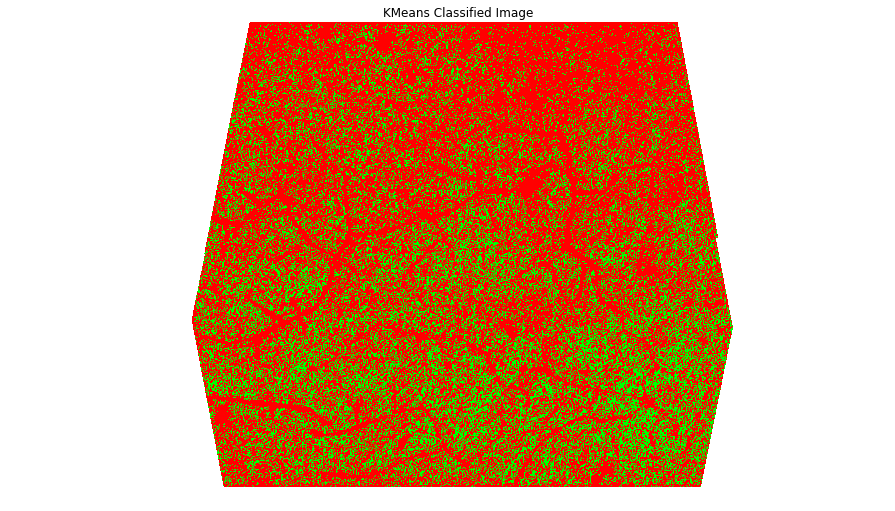

In [151]:
# separate the class numbers into rgb bands
def classified_band_to_rgb(classified_band):
    return [classified_band == n for n in [0,1,2]]

visual.plot_image(classified_band_to_rgb(y_band), title='KMeans Classified Image', figsize=(15, 15))

## Temporal Classification

Lets look at the time series information for each pixel and see if we can identify true change

In [ ]:
def get_strip_date(strip_id):
    strip_scenes = overlapping_scenes[overlapping_scenes.strip_id == strip_id]
    strip_dates = set([a.date() for a in strip_scenes.acquired.tolist()])
    assert len(strip_dates) == 1
    return strip_dates.pop()

test_strip_id = '943459'
get_strip_date(test_strip_id)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# get time series for each unmasked pixel
pixel_timeseries = np.ma.compress_cols(np.ma.dstack(classified_bands).transpose(2, 0, 1).reshape(9, -1)).transpose(1,0)
pixel_timeseries.shape

In [ ]:
def make_sample(pixels, count):
    pixel_sample = pixels.copy()
    np.random.shuffle(pixel_sample) # only shuffles along the first axis
    pixel_sample = pixel_sample[:count, :]
    return pixel_sample

make_sample(pixel_timeseries, 6).shape

In [ ]:
def make_same_size_samples(list_of_pixel_sets):
    sample_len = min([p.shape[0] for p in list_of_pixel_sets])

    def sample_pixels(pixels):
        if pixels.shape[0] > sample_len:
            pixel_sample = make_sample(pixels, sample_len)
        else:
            pixel_sample = pixels
        return pixel_sample
    
    return [sample_pixels(p)
            for p in list_of_pixel_sets]

forest_pixels = pixel_timeseries[pixel_timeseries[:,0] == 0]
non_forest_pixels = pixel_timeseries[pixel_timeseries[:,0] == 1]
forest_pixels_sample, non_forest_pixels_sample = make_same_size_samples([forest_pixels, non_forest_pixels])
print(forest_pixels_sample.shape)
print(non_forest_pixels_sample.shape)

In [ ]:
forest_plot_sample = make_sample(forest_pixels_sample, 6)
non_forest_plot_sample = make_sample(non_forest_pixels_sample, 6)

In [ ]:
plt.figure()
for i, pixel in enumerate(forest_plot_sample):
    plt.plot(np.array(range(len(pixel))), pixel, 'o--', label=i)
# plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.figure()
for i, pixel in enumerate(non_forest_plot_sample):
    plt.plot(np.array(range(len(pixel))), pixel, 'o--', label=i)
# plt.legend(loc='upper left')
plt.show()